In [1]:
%load_ext autoreload

In [2]:
import os
os.chdir('..')
!export PYTHONPATH=$(pwd):$PYTHONPATH
import parkinson
from typing import List, Tuple

import torch
from torch import nn
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, TopKPooling
from torch.nn import Linear
from torch_geometric.loader import DataLoader
from torch.utils.data import WeightedRandomSampler

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

In [3]:
SAVE_PATH = '../outputs/3.0_gnn'

# Processamento dos dados

In [4]:
parkinson_data = parkinson.utils.data.batch_read('data/PDs_columns')
control_data = parkinson.utils.data.batch_read('data/Controls_columns')

100%|██████████| 66/66 [00:03<00:00, 21.06it/s]


In [5]:
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')

parkinson_correlation_matrix = [ts.corr(method='pearson').to_numpy() for ts in parkinson_atlas_data]
control_correlation_matrix = [ts.corr(method='pearson').to_numpy() for ts in control_atlas_data]

X_matrix = np.concatenate([parkinson_correlation_matrix, control_correlation_matrix], axis=0)
y = np.concatenate([
    [1 for _ in range(len(parkinson_data))],
    [0 for _ in range(len(control_data))]
], axis=0)

X_matrix, y = parkinson.utils.data.filter_data(X_matrix, y)

In [6]:
# Implementação do OMST (Orthogonal Minimal Spanning Tree)
class OMSTBuilder: # teste 1234
    """ Orthogonal Minimal Spanning Tree (OMST) Builder
    A classe encontra iterativamente as Orthogonal Minimal Spanning Trees (OMSTs)
    e as adicionam a um grafo cumulativo, parando a
    Eficiência do Custo Global (GCE) quando não há mais aumento.
    """

    def __init__(self, adj_matrix: np.ndarray):

        if not isinstance(adj_matrix, np.ndarray) or adj_matrix.ndim != 2 or adj_matrix.shape[0] != adj_matrix.shape[1]:
            raise ValueError("Input must be a square 2D NumPy array.")

        # Correspondente ao input 'CIJ' no script MATLAB.
        # Utilizando abs() para garantir pesos positivos, típico das matrizes de correlação.
        self.adj_matrix = np.abs(adj_matrix)
        self.n_nodes = self.adj_matrix.shape[0]

        # --- Inicializa as métricas do grafo original ---
        # Correspondente à 'cost_ini'
        self._initial_cost = np.sum(np.triu(self.adj_matrix))
        # Correspondente à 'E_ini'
        self._initial_ge = self._calculate_global_efficiency_from_matrix(self.adj_matrix)

        # --- Initialize graphs for the build process ---
        # Correspondente à 'CIJnotintree' - grafo das arestas restantes.
        # Utilizando grafos NetworkX para eficiência.
        self._residual_graph = self._create_distance_graph(self.adj_matrix)

        # --- Atributos públicos para armazenar os resultados ---
        self.omsts: List[nx.Graph] = []
        self.gce_scores: List[float] = []
        self.final_graph: nx.Graph = nx.Graph()

    def _create_distance_graph(self, matrix: np.ndarray) -> nx.Graph:
        """
        Auxiliar para criar um grafo ponderado por distância a partir de uma matriz de similaridade.
        Nos grafos de distância, menor peso é melhor.
        Correspondente à `1./CIJ` no script MATLAB.
        """
        with np.errstate(divide='ignore', invalid='ignore'):
            distance_matrix = 1 / matrix
        # Definido valores não-finitos (1/0 ou NaNs) para 0, indicando nenhum caminho.
        distance_matrix[~np.isfinite(distance_matrix)] = 0
        return nx.from_numpy_array(distance_matrix)

    def _calculate_global_efficiency_from_matrix(self, matrix: np.ndarray) -> float:
        """Calcula a eficiência global da matriz de similaridade."""
        dist_graph = self._create_distance_graph(matrix)
        return nx.global_efficiency(dist_graph)

    def _calculate_gce(self, graph: nx.Graph) -> float:
        """
        Calcula a Eficiência de Custo Global para o grafo cumulativo atual.
        Correspondente à formula `E/E_ini - cost(counter)`.
        """
        if self._initial_cost == 0 or self._initial_ge == 0:
            return -np.inf

        # Custo é a soma dos pesos (similaridade) como uma fração do custo total inicial.
        current_cost = graph.size(weight='weight') / self._initial_cost

        # Eficiência calculada no ggrafo de distância correspondente.
        current_ge = self._calculate_global_efficiency_from_matrix(nx.to_numpy_array(graph))
        
        return (current_ge / self._initial_ge) - current_cost

    def build(self, verbose: bool = True) -> 'OMSTBuilder':
        """
        Executa o processo de construção iterativo, correspondente ao loop principal
        `while delta > 0` no script MATLAB.

        Args:
            verbose: Se verdadeiro, imprime a pontuação do GCE em cada iteração.

        Retorna:
            A própria instância, permitindo o encadeamento de métodos (por exemplo, builder.build().plot()).
        """
        # Este grafo acumulará as arestas dos OMSTs encontrados.
        cumulative_graph = nx.Graph()
        previous_gce = -np.inf

        if verbose:
            print(f"Starting build. Initial GE={self._initial_ge:.4f}, Initial Cost={self._initial_cost:.2f}")
            print("-" * 30)

        for i in range(self.n_nodes * (self.n_nodes - 1) // 2): # Max possible iterations
            if self._residual_graph.number_of_edges() == 0:
                if verbose: print("\nNo more edges available. Stopping.")
                break

            # Encontrando o próximo MST a partir das arestas restantes.
            mst = nx.minimum_spanning_tree(self._residual_graph, weight='weight')
            if mst.number_of_edges() == 0:
                if verbose: print("\nGraph disconnected. Stopping.")
                break
            
            candidate_graph = cumulative_graph.copy()
            for u, v in mst.edges():
                weight = self.adj_matrix[u, v]
                candidate_graph.add_edge(u, v, weight=weight)

            # Calculando o GCE deste novo grafo candidato.
            current_gce = self._calculate_gce(candidate_graph)

            if verbose:
                print(f"Iteration {i+1}: GCE = {current_gce:.4f}")

            # Condição de parada: se GCE não melhorar, grafo ótimo encontrado.
            if current_gce < previous_gce:
                if verbose:
                    print(f"GCE decreased. Halting at {len(self.omsts)} OMST(s).")
                    print("-" * 30)
                break

            previous_gce = current_gce
            self.gce_scores.append(current_gce)
            self.omsts.append(mst)
            cumulative_graph = candidate_graph
 
            self._residual_graph.remove_edges_from(mst.edges())
        
        self.final_graph = cumulative_graph
        return self

    def plot_gce_curve(self):
        """Traçando a pontuação do GCE em relação ao número de OMSTs adicionados."""
        if not self.gce_scores:
            print("No scores to plot. Run .build() first.")
            return

        plt.figure(figsize=(10, 6))
        iterations = range(1, len(self.gce_scores) + 1)
        plt.plot(iterations, self.gce_scores, marker='o', linestyle='-')
        
        max_gce = max(self.gce_scores)
        max_idx = self.gce_scores.index(max_gce)
        plt.plot(max_idx + 1, max_gce, 'r*', markersize=15, label=f'Max GCE: {max_gce:.4f}')
        
        plt.title("Global Cost Efficiency vs. Number of OMSTs")
        plt.xlabel("Number of OMSTs Added")
        plt.ylabel("Global Cost Efficiency (GCE)")
        plt.grid(True)
        plt.legend()
        plt.show()
        
np.random.seed(42)
adj = parkinson_correlation_matrix[1].copy()  # Use the first patient's correlation matrix

# Construindo o grafo ótimo
OMST = OMSTBuilder(adj)
OMST.build(verbose=True)

Starting build. Initial GE=1.0000, Initial Cost=2430.58
------------------------------
Iteration 1: GCE = 0.0916
Iteration 2: GCE = 0.1705
Iteration 3: GCE = 0.2039
Iteration 4: GCE = 0.2209
Iteration 5: GCE = 0.2309
Iteration 6: GCE = 0.2326
Iteration 7: GCE = 0.2304
GCE decreased. Halting at 6 OMST(s).
------------------------------



--- Results ---
Optimal number of OMSTs: 6
Final Graph Edges: 990
Maximum GCE achieved: 0.2326


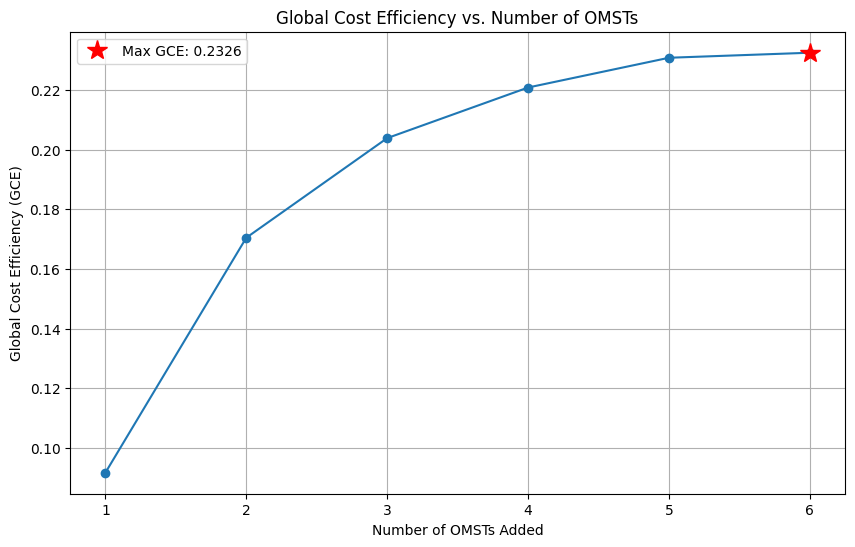

In [7]:
# Mostrando resultados
print("\n--- Results ---")
print(f"Optimal number of OMSTs: {len(OMST.omsts)}")
print(f"Final Graph Edges: {OMST.final_graph.number_of_edges()}")
if OMST.gce_scores:
    print(f"Maximum GCE achieved: {max(OMST.gce_scores):.4f}")

# Plotando a curva GCE
OMST.plot_gce_curve()

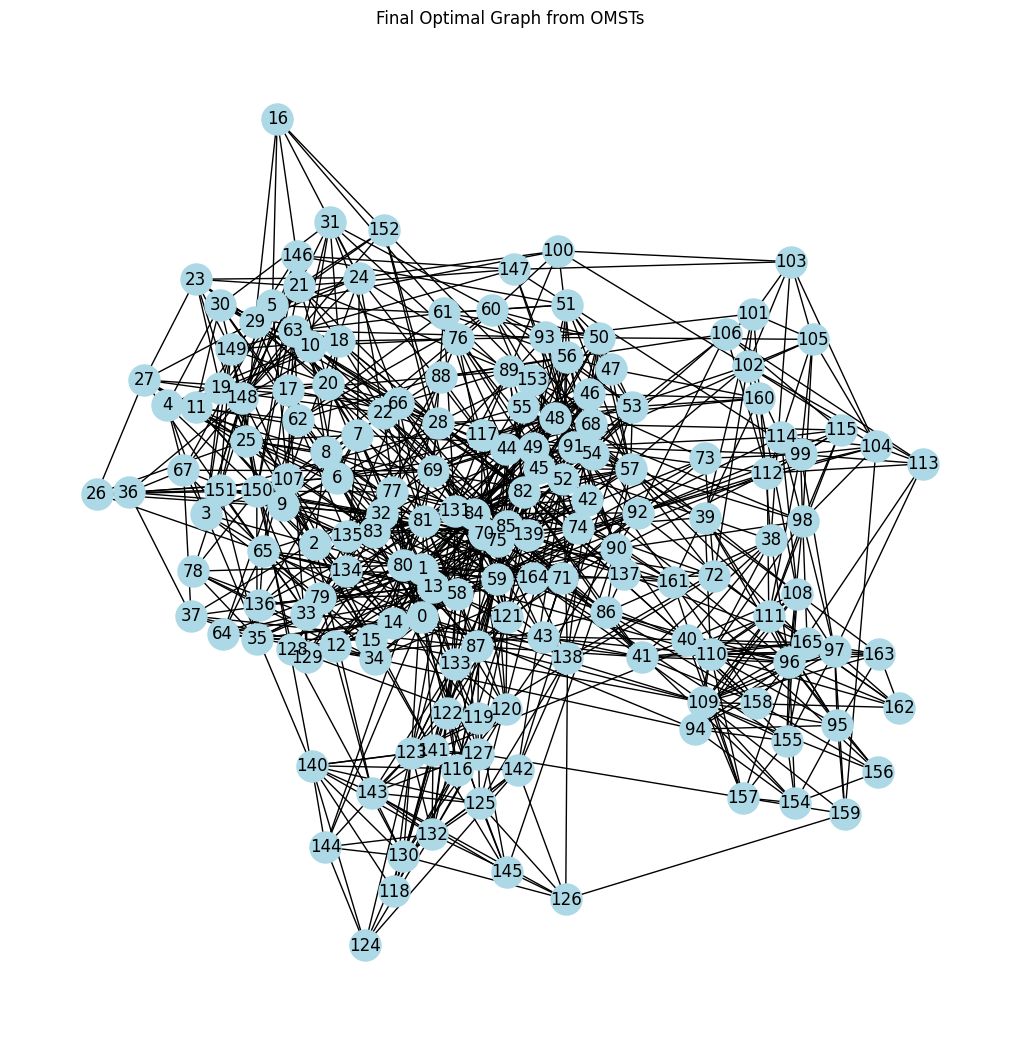

In [8]:
G = OMST.final_graph

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500)
plt.title("Final Optimal Graph from OMSTs")
plt.show()  

-----------

### Computando OMST para todos os pacientes

In [9]:
Control_omst_graphs = []
for i in tqdm(range(len(control_correlation_matrix))):
    adj = control_correlation_matrix[i].copy()
    omst_builder = OMSTBuilder(adj)
    omst_builder.build(verbose=False)
    Control_omst_graphs.append(omst_builder.final_graph.to_undirected())

Parkinson_omst_graphs = []
for i in tqdm(range(len(parkinson_correlation_matrix))):
    adj = parkinson_correlation_matrix[i].copy()
    omst_builder = OMSTBuilder(adj)
    omst_builder.build(verbose=False)
    Parkinson_omst_graphs.append(omst_builder.final_graph.to_undirected())

100%|██████████| 153/153 [01:09<00:00,  2.19it/s]


### Construção das Node Features

Vamos usar a abordagem 'Connection Profile'. Um "connection profile" para um nó simples (um ROI) é seu padrão único de conectividade com os outros nós do cérebro. Em termos práticos, corresponde a uma linha (ou coluna, pois a matriz é simétrica) da matriz de conectividade fncional.

In [10]:
# Convertendo o grafo final para PyTorch Geometric Data object
def graph_to_pyg_data(graph: nx.Graph, X_matrix: np.ndarray) -> Data:
    edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor([graph[u][v]['weight'] for u, v in graph.edges], dtype=torch.float).view(-1, 1)
    x = torch.tensor(X_matrix, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [11]:
X = []
y = []
for i, graph in enumerate(tqdm(Control_omst_graphs + Parkinson_omst_graphs)):
    label = 0 if graph in Control_omst_graphs else 1
    pyg_data = graph_to_pyg_data(graph, X_matrix[i])
    pyg_data.y = torch.tensor([label], dtype=torch.long)  # Definindo o label como tensor
    y.append(label)
    X.append(pyg_data)

100%|██████████| 219/219 [00:00<00:00, 974.80it/s]


------

### Construindo a GNN

In [12]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_feats, hidden_feats, num_classes, dropout=0.4):
        super(GCNNet, self).__init__()
        self.conv1 = GCNConv(in_feats, hidden_feats)
        self.lin = torch.nn.Linear(hidden_feats, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, edge_attr, batch):
        x = F.relu(self.conv1(x, edge_index, edge_weight=edge_attr))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x

# Treinamento

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    logits_list, y_true_list = [], []
    for batch in loader:
        batch = batch.to(device)
        logits = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        logits_list.append(logits.cpu())
        y_true_list.append(batch.y.cpu())
    y_pred = torch.cat(logits_list)
    y_true = torch.cat(y_true_list)

    probs = F.softmax(y_pred, dim=1).numpy()
    preds = y_pred.argmax(dim=1).numpy()
    true = y_true.numpy()

    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds, average='weighted')
    true_bin = label_binarize(true, classes=[0,1])
    auc = roc_auc_score(true, probs[:, 1])
    return acc, f1, auc, true, preds


In [15]:
# Divisão dos dados: 60% treino, 20% validação, 20% teste
X_list = X  # X já é uma lista de Data
y_np = np.array(y)

X_trainval, X_test, y_trainval, y_test = train_test_split(X_list, y_np, test_size=0.2, random_state=42, stratify=y_np)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)

# Weighted sampler para lidar com desbalanceamento
class_counts = np.bincount(y_train)
class_weights = 1. / class_counts
sample_weights = np.array([class_weights[label] for label in y_train])
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(X_train, batch_size=32, sampler=sampler)
val_loader = DataLoader(X_val, batch_size=32, shuffle=False)
test_loader = DataLoader(X_test, batch_size=32, shuffle=False)

# Modelo, otimizador, scheduler, loss
model = GCNNet(in_feats=X[0].num_node_features, hidden_feats=16, num_classes=3, dropout=0.4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
criterion = torch.nn.CrossEntropyLoss()

best_val = float('inf')
patience = 0
max_patience = 10
for epoch in range(1, 51):
    loss = train_epoch(model, train_loader, optimizer, criterion, device)
    acc, f1, auc, _, _ = evaluate(model, val_loader, device)
    val_metric = -auc  # maximize AUC
    scheduler.step(val_metric)

    if val_metric < best_val:
        best_val = val_metric
        torch.save(model.state_dict(), 'weights/3.0_gnn/best_model.pt')
        patience = 0
    else:
        patience += 1
        if patience >= max_patience:
            break

# Avaliação no conjunto de teste
model.load_state_dict(torch.load('weights/3.0_gnn/best_model.pt'))
acc, f1, auc, true, preds = evaluate(model, test_loader, device)
print(f"Test — Acc: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
print(classification_report(true, preds))

Test — Acc: 0.4091, F1: 0.4189, AUC: 0.4764
              precision    recall  f1-score   support

           0       0.28      0.62      0.38        13
           1       0.67      0.32      0.43        31

    accuracy                           0.41        44
   macro avg       0.47      0.47      0.41        44
weighted avg       0.55      0.41      0.42        44

